In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from os.path import join
from tqdm.notebook import tqdm
import os
from os.path import basename
from config import raw_data_path, processed_data_path
import time
%load_ext autotime
%matplotlib inline 


time: 2.92 ms (started: 2021-07-30 11:37:45 +01:00)


# Sanity checks
### Listing all the files on the bkg and signal directory (file path)

In [2]:
bkg_files = glob.glob(join(raw_data_path, "bkg.*"))
signal_files = list(set(glob.glob(join(raw_data_path, "*.*"))) - set(bkg_files))
all_files = bkg_files + signal_files

print("Signal files:", len(signal_files), "\nBackground files:", len(bkg_files), "\n> Total:", len(all_files))

Signal files: 7 
Background files: 1 
> Total: 8
time: 1.19 ms (started: 2021-07-30 11:37:45 +01:00)


## Checking features

In [3]:
book = {}

for path in all_files:
    # Load data
    if path.endswith(".csv"):
        data = pd.read_csv(path)
    elif path.endswith(".h5"):
        data = pd.read_hdf(path)

    # Get features
    features = list(data.columns)

    file_name = basename(path)
    for feature in features:
        if feature not in book:
            book[feature] = []
        book[feature] += [file_name]

    # Saving memory
    del data

time: 7.4 s (started: 2021-07-30 11:37:45 +01:00)


After getting a directory with the structure:
- {feature:\[name_of_file\]}

We can compare each of the files features to see if they match

In [4]:
problematic_features = []
for x in book:
    if x.startswith("gen"):
        problematic_features.append(x)
    elif len(book[x]) != len(all_files):
        problematic_features.append(x)
        print(f"\nFeature \"{x}\" is missing on",  len(all_files)-len(book[x]), "file(s).")
        print("-> Files that are missing the feature:\n\t", set([basename(x) for x in all_files]) - set(book[x]))
    else:
        pass


Feature "Jet10_BTag" is missing on 1 file(s).
-> Files that are missing the feature:
	 {'bkg.h5'}

Feature "Jet10_Eta" is missing on 1 file(s).
-> Files that are missing the feature:
	 {'bkg.h5'}

Feature "Jet10_Mass" is missing on 1 file(s).
-> Files that are missing the feature:
	 {'bkg.h5'}

Feature "Jet10_PT" is missing on 1 file(s).
-> Files that are missing the feature:
	 {'bkg.h5'}

Feature "Jet10_Phi" is missing on 1 file(s).
-> Files that are missing the feature:
	 {'bkg.h5'}

Feature "Jet6_BTag" is missing on 1 file(s).
-> Files that are missing the feature:
	 {'bkg.h5'}

Feature "Jet6_Eta" is missing on 1 file(s).
-> Files that are missing the feature:
	 {'bkg.h5'}

Feature "Jet6_Mass" is missing on 1 file(s).
-> Files that are missing the feature:
	 {'bkg.h5'}

Feature "Jet6_PT" is missing on 1 file(s).
-> Files that are missing the feature:
	 {'bkg.h5'}

Feature "Jet6_Phi" is missing on 1 file(s).
-> Files that are missing the feature:
	 {'bkg.h5'}

Feature "Jet7_BTag" is

Since the features highlighted by out little script are irrelevant, we can just mass-delete them on all the files when we pre-process the data.

# Pre-Processing
-> Delete irrelevant features (ex: features that were used on the simulation of the data)

-> Apply Cuts

- At least two final state leptons

- At least one b-tagged jet

- Large scalar sum of transverse momentum (p_t), H_t > 500 GeV

-> Weight the data


### Pre-process and join all the background data

In [5]:
# This features shall be removed
to_remove = list(set([
        'gen_decay1',
        'gen_decay2',
        'gen_sample',
        'gen_filter',
        'gen_decay_filter',
        'MissingET_Eta',
        'gen_label',
        'gen_n_btags',
        'gen_sample_filter',
        'gen_split'
            ] + problematic_features))
to_remove.remove("gen_xsec")

def pre_process(paths):
    print("[Info] Started preprocessing..")
    #keys = set([x.split("/")[-2] for x in all_files])
    #print(f"[Info] Keys: {keys}\n")

    for i, path in enumerate(tqdm(paths)):
        # Load data
        if path.endswith(".csv"):
            data = pd.read_csv(path, index_col=0)
        elif path.endswith(".h5"):
            data = pd.read_hdf(path, index_col=0)
        # Remove ussless features
        for x in to_remove:
            try:
                data.drop([x], axis=1, inplace=True)
            except:
                pass

        data = data.astype('float32')

        ## Apply Cuts
        # Statistical purposes
        shape_before = data.shape[0]
        # At least 2 leptons
        data = data[(data['Electron_Multi'] + data['Muon_Multi']) >= 2] 
        # At least 1 B-Tag
        data = data[(data['Jet1_BTag'] + data['Jet2_BTag'] + data['Jet3_BTag'] + data['Jet4_BTag'] + data['Jet5_BTag']) >= 1]
        # H_T > 500 GeV
        data = data[data['ScalarHT_HT'] > 500]
        # Statistical purposes
        shape_after = data.shape[0]
        print(f"[Info] Data Reduction for \"{basename(path)}\": {int(((shape_before-shape_after)/shape_before)*100)}%")

        ## Weights
        data["gen_xsec"] = data["gen_xsec"].mean() / data.shape[0]
        data.rename(columns={"gen_xsec":"weights"}, inplace=True)
        # Save column for not being afected in the folowing operations
        weights = data['weights']
        data.drop(['weights'], axis=1, inplace=True)

        # In order to have std = 1 and mean = 0
        data = (data-data.mean())/data.std()
        data.fillna(0.0, inplace=True) # 0/0 = NaN, this solves that issue

        # Here we reatatch the weights
        data = data.join(weights)

        # Add a column with the file name for later reference
        data["name"] = basename(path)

        # Reset index
        data.reset_index(inplace=True, drop=True)

        ## SAVING
        save_path = join(processed_data_path, basename(path))

        # TODO: Create / Reset file on first iteration 
        data.to_hdf(save_path, key=basename(path).replace(".h5", ""))
        
        #with open(save_path, 'a') as f:
        #    data.to_csv(f, header=f.tell()==0)


time: 768 µs (started: 2021-07-30 11:37:53 +01:00)


In [6]:
pre_process(all_files)

[Info] Started preprocessing..


  0%|          | 0/8 [00:00<?, ?it/s]

[Info] Data Reduction for "bkg.h5": 0%
[Info] Data Reduction for "wohg_hq1000.h5": 3%
[Info] Data Reduction for "hg3000_hq1200.h5": 2%
[Info] Data Reduction for "hg3000_hq1000.h5": 2%
[Info] Data Reduction for "wohg_hq1400.h5": 3%
[Info] Data Reduction for "hg3000_hq1400.h5": 2%
[Info] Data Reduction for "fcnc.h5": 0%
[Info] Data Reduction for "wohg_hq1200.h5": 3%
time: 7.45 s (started: 2021-07-30 11:37:53 +01:00)


# Data Visualisation

Loading the processed data

In [7]:
bkg_data = pd.read_hdf(join(processed_data_path,  "bkg.h5"), index_col=0)
signal_data = pd.concat(
    [pd.read_hdf(path, index_col=0) for path in glob.glob(join(processed_data_path, "[!bkg]*"))]
)

bkg_data.shape, signal_data.shape

((1002490, 49), (250202, 49))

time: 445 ms (started: 2021-07-30 11:38:00 +01:00)


In [8]:
bkg_data.columns

Index(['Electron_Multi', 'FatJet1_Eta', 'FatJet1_Mass', 'FatJet1_PT',
       'FatJet1_Phi', 'FatJet1_Tau1', 'FatJet1_Tau2', 'FatJet1_Tau3',
       'FatJet1_Tau4', 'FatJet1_Tau5', 'FatJet_Multi', 'Jet1_BTag', 'Jet1_Eta',
       'Jet1_Mass', 'Jet1_PT', 'Jet1_Phi', 'Jet2_BTag', 'Jet2_Eta',
       'Jet2_Mass', 'Jet2_PT', 'Jet2_Phi', 'Jet3_BTag', 'Jet3_Eta',
       'Jet3_Mass', 'Jet3_PT', 'Jet3_Phi', 'Jet4_BTag', 'Jet4_Eta',
       'Jet4_Mass', 'Jet4_PT', 'Jet4_Phi', 'Jet5_BTag', 'Jet5_Eta',
       'Jet5_Mass', 'Jet5_PT', 'Jet5_Phi', 'Jet_Multi', 'Lepton1_Eta',
       'Lepton1_PT', 'Lepton1_Phi', 'Lepton2_Eta', 'Lepton2_PT', 'Lepton2_Phi',
       'MissingET_MET', 'MissingET_Phi', 'Muon_Multi', 'ScalarHT_HT',
       'weights', 'name'],
      dtype='object')

time: 1.85 ms (started: 2021-07-30 11:38:01 +01:00)


In [9]:

def plot_graphs2(background, signal, bins=50, num_cols=4):
    """
    Esta função da plot a dois df tendo em conta os weights e 
    assumindo que ambos os df têm as mesmas columns
    """

    # Ignoring irrelevant features such as 'name' and 'weights' in
    # the plotting of the data
    features  = list(signal.columns)
    for x in ['name', 'weights']: 
        features.remove(x)

    # Plot creation
    num_rows = int(np.ceil((len(list(signal.columns)) - 1) / num_cols))
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        i +=1

        # Define histogram range
        hist_min = min(signal[x].min(), background[x].min())
        hist_max = max(signal[x].max(), background[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(background[x], bins=bins, alpha=0.5, label='Background', weights=background['weights'], range=hist_range)
        ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label='Sinal', weights=signal['weights'], range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()

    fig.tight_layout()
    plt.savefig('data_exploratio.png', bbox_inches='tight', dpi=100)
    plt.show()
    

time: 761 µs (started: 2021-07-30 11:38:01 +01:00)


Processing...:   0%|          | 0/47 [00:00<?, ?it/s]

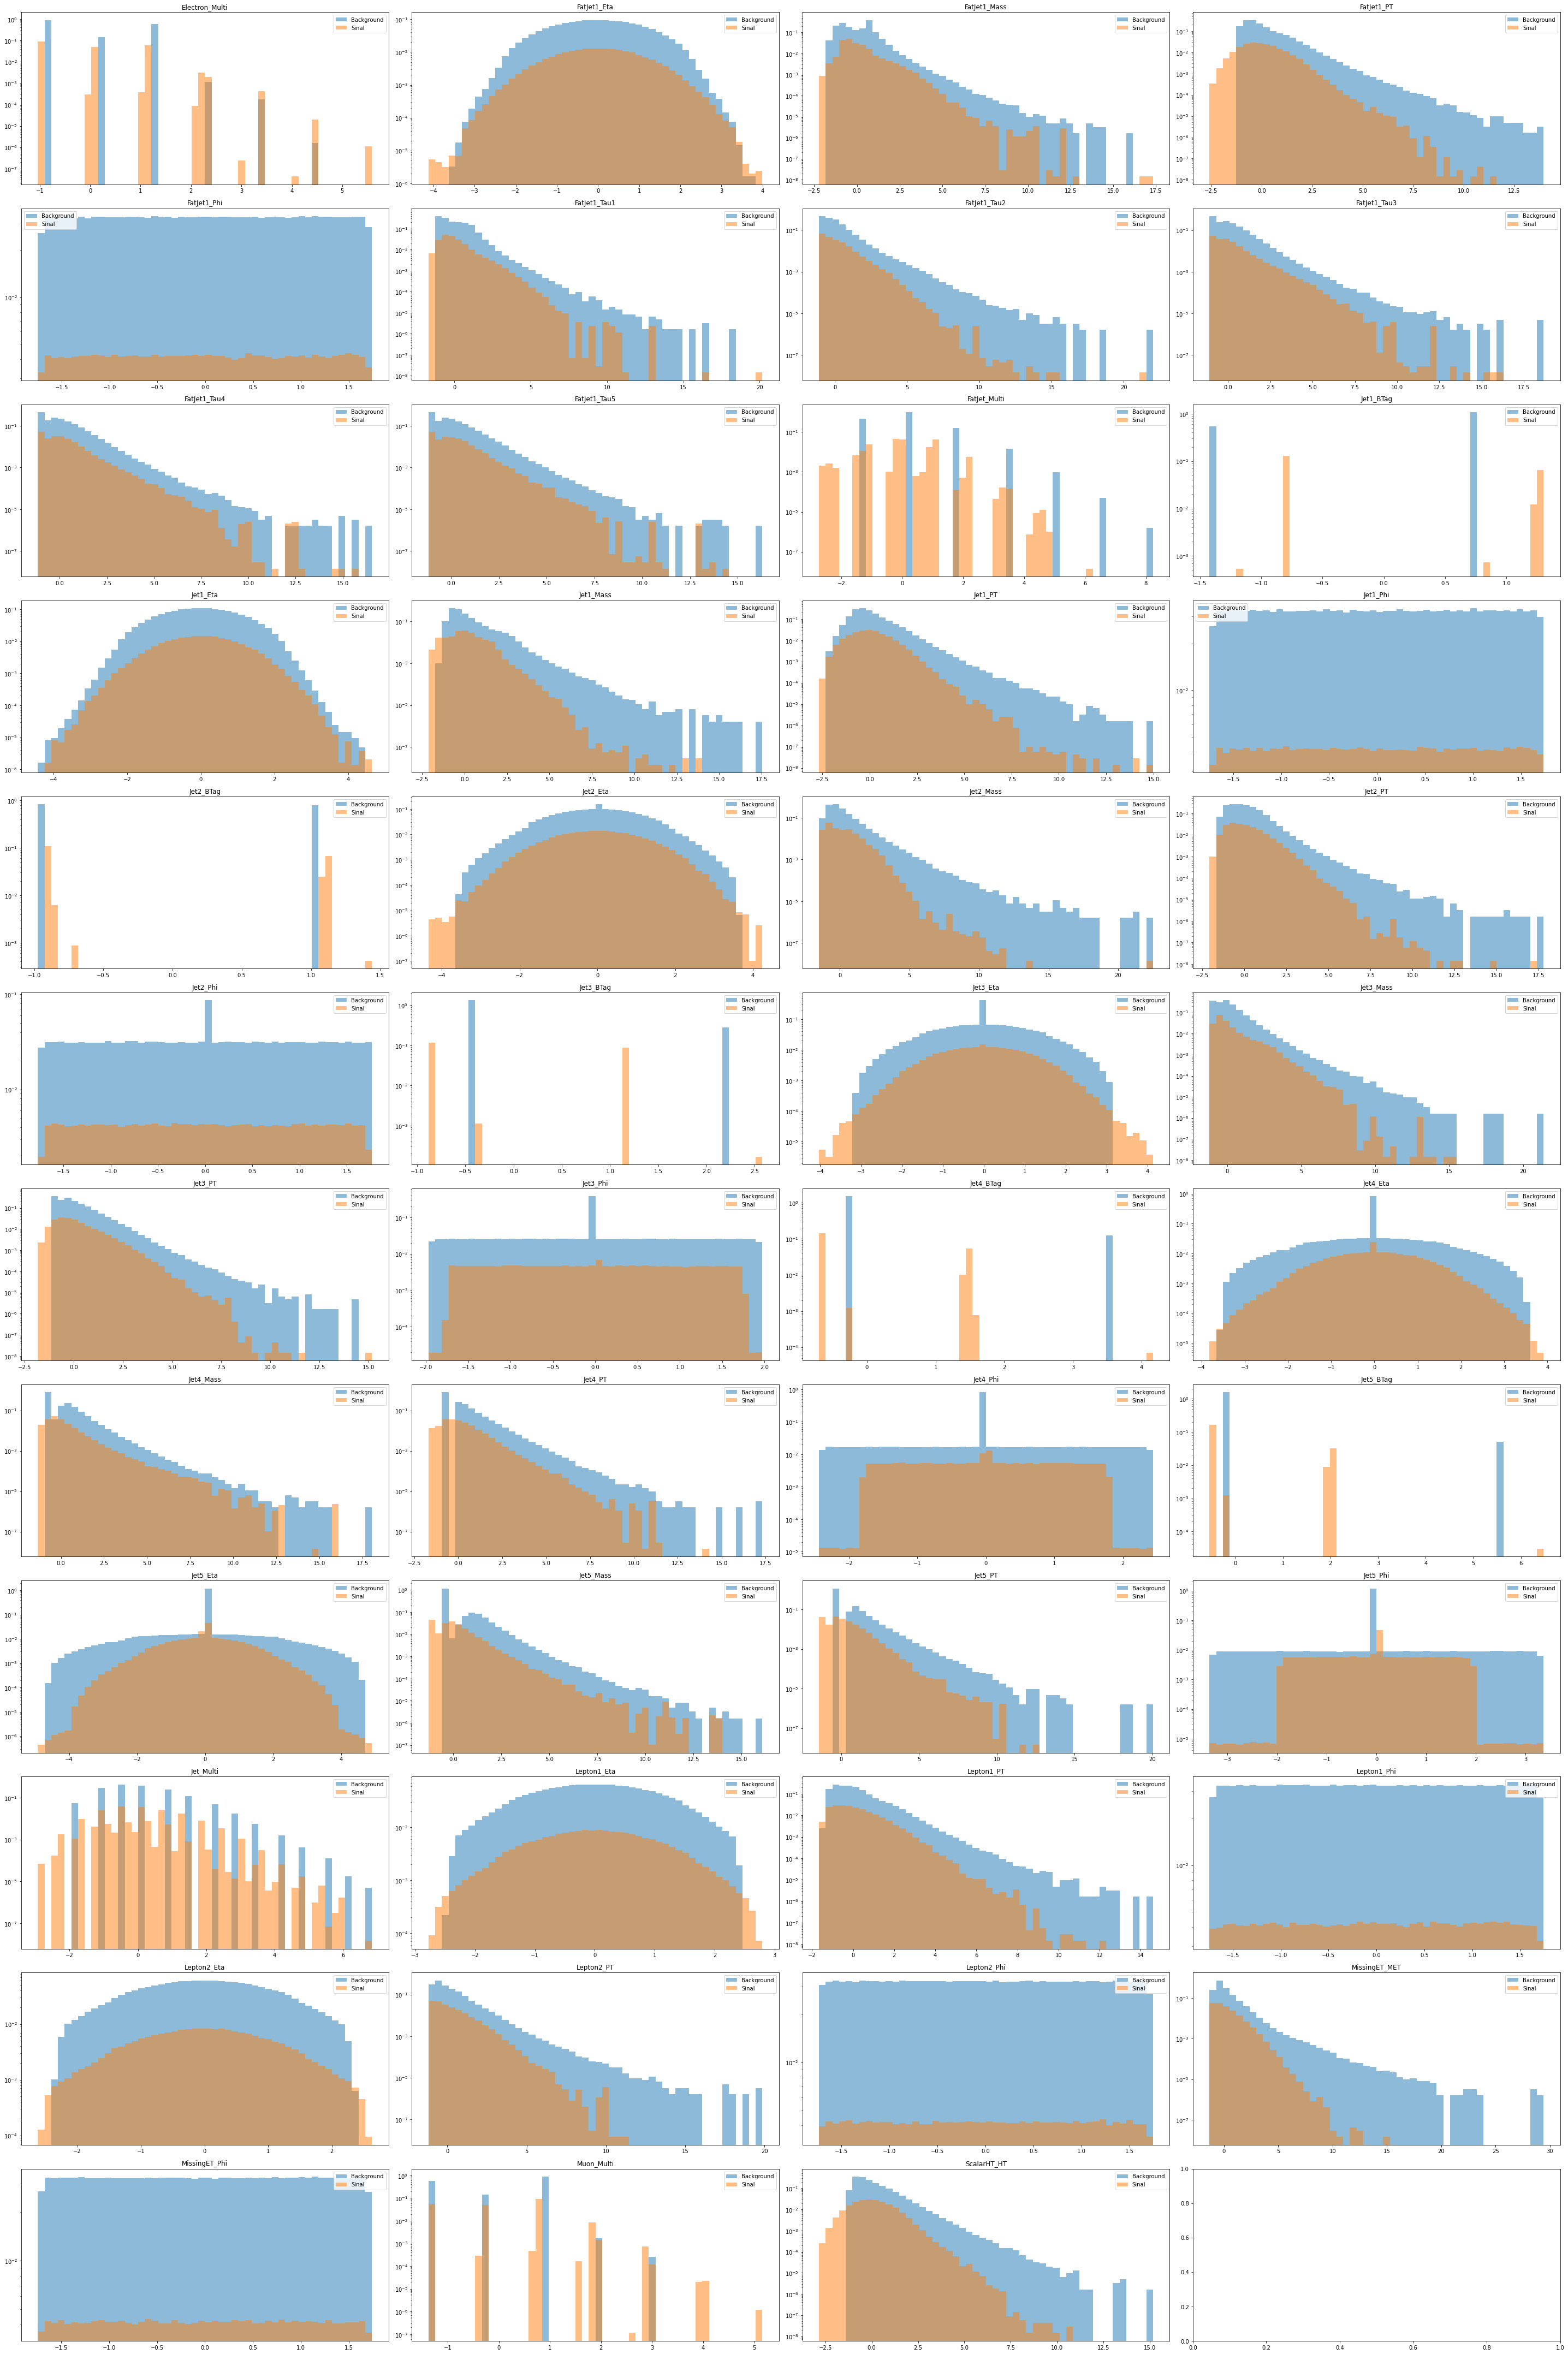

time: 33.7 s (started: 2021-07-30 11:38:02 +01:00)


In [10]:
plot_graphs2(bkg_data, signal_data)

In [12]:
bkg_data.shape, signal_data.shape

((1002490, 49), (250202, 49))

time: 1.44 ms (started: 2021-07-30 11:55:43 +01:00)


In [ ]:
bkg_data.columns